# Integrating the RNN+CNN and LLMs into a single model

### Importing Required Libraries

In [40]:
import torch
from torch import nn
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tiktoken


In [41]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Loading the RNN + CNN model

In [42]:
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents = True,
                 exist_ok=True)
MODEL_NAME = 'Sensor_Data_predictor.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

In [43]:
class Sequence_Identifier(nn.Module):
    def __init__(self,
                 input_shape: int,
                 cnn_hidden: int,
                 rnn_hidden: int,
                 rnn_layer: int,
                 output_shape:int):
        super().__init__()
        self.dropout = nn.Dropout(p=0.45)
        self.conv_block_1 = nn.Sequential(
            nn.Conv1d(in_channels=input_shape,
                      out_channels=cnn_hidden*2,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=cnn_hidden*2,
                      out_channels=cnn_hidden,
                      kernel_size=3,
                      stride = 1,
                      padding =1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2,
                         stride=1))
        self.rnn = nn.GRU(
            input_size = cnn_hidden,
            hidden_size = rnn_hidden,
            batch_first = True,
            num_layers= rnn_layer,
            bidirectional= True,
            dropout= 0.3)
        self.fc = nn.Linear(rnn_hidden *2, output_shape)

    def forward(self,x):
        x = x.unsqueeze(1) #Conv1d expects (batch, channels, length)
        x = self.conv_block_1(x)
        x = self.dropout(x)
        
        x = x.permute(0,2,1 )   # (batch, new_len, cnn_hidden)
        out, _ = self.rnn(x)
        out = self.dropout(out)
        out = out[:,-1,:]       # Use last time step
        out = self.fc(out)      # [batch, num_classes]
        return out

In [44]:
torch.manual_seed(42)
model_loaded = Sequence_Identifier(
    input_shape = 1,
    cnn_hidden = 64,
    rnn_hidden = 64,
    rnn_layer = 2,
    output_shape = 6    
).to(device)

print(f'Loading Model from: {MODEL_SAVE_PATH}')
model_loaded.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

model_loaded.to(device)

Loading Model from: models\Sensor_Data_predictor.pth


C:\Users\SUBHO\AppData\Local\Temp\ipykernel_32888\1502101415.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_loaded.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

Sequence_Identifier(
  (dropout): Dropout(p=0.45, inplace=False)
  (conv_block_1): Sequential(
    (0): Conv1d(1, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU()
    (4): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (rnn): GRU(64, 64, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)

In [45]:
model_loaded.eval()

Sequence_Identifier(
  (dropout): Dropout(p=0.45, inplace=False)
  (conv_block_1): Sequential(
    (0): Conv1d(1, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU()
    (4): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (rnn): GRU(64, 64, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)

### Loading the LLM

In [46]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

In [47]:
# Define model configurations in a dictionary for compactness
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# Copy the base configuration and update with specific model settings
model_name = "gpt2-small (124M)"  # Example model name
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])


In [48]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) 
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2) 
        
        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

In [49]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

In [50]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

In [51]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

In [52]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], 
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x

In [53]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [54]:
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})
gpt = GPTModel(NEW_CONFIG)
gpt.eval();

In [55]:
SUBFILE_NAME = "gpt2-small124M-sft.pth"
FILE_NAME = MODEL_PATH / SUBFILE_NAME

In [56]:
gpt.load_state_dict(torch.load(FILE_NAME))
gpt.to(device);

C:\Users\SUBHO\AppData\Local\Temp\ipykernel_32888\606192599.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gpt.load_state_dict(torch.load(FILE_NAME))


In [57]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

In [58]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    
    for _ in range(max_new_tokens):
        
        
        idx_cond = idx[:, -context_size:]
        
        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond) # batch, n_tokens, vocab_size
        
       
        logits = logits[:, -1, :]  

        # Applying softmax along the columns to get probabilities
        probas = torch.softmax(logits, dim=-1) 

        # Getting the idx of the vocab entry with the highest probability value along column
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  

        # Appending sampled index to the running sequence along column
        idx = torch.cat((idx, idx_next), dim=1)

    return idx

In [59]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

### Loading the Dataset

In [60]:
sensor_data_path = Path(r'F:\Python_Projects\Learning\Neural_Networks\data\human+activity+recognition+using+smartphones\UCI HAR Dataset\UCI HAR Dataset')

In [61]:
txt_list = list(sensor_data_path.glob('*/*.txt'))
txt_list

[WindowsPath('F:/Python_Projects/Learning/Neural_Networks/data/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/test/subject_test.txt'),
 WindowsPath('F:/Python_Projects/Learning/Neural_Networks/data/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/test/X_test.txt'),
 WindowsPath('F:/Python_Projects/Learning/Neural_Networks/data/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/test/y_test.txt'),
 WindowsPath('F:/Python_Projects/Learning/Neural_Networks/data/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/train/subject_train.txt'),
 WindowsPath('F:/Python_Projects/Learning/Neural_Networks/data/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/train/X_train.txt'),
 WindowsPath('F:/Python_Projects/Learning/Neural_Networks/data/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/train/y_train.txt')]

In [62]:
x_train = pd.read_csv(sensor_data_path / 'train' / 'X_train.txt', delim_whitespace=True, header=None)
y_train = pd.read_csv(sensor_data_path / 'train' / 'y_train.txt', delim_whitespace=True, header=None)
x_test = pd.read_csv(sensor_data_path / 'test' / 'X_test.txt', delim_whitespace=True, header=None)
y_test = pd.read_csv(sensor_data_path / 'test' / 'y_test.txt', delim_whitespace=True, header=None)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

C:\Users\SUBHO\AppData\Local\Temp\ipykernel_32888\1007515285.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  x_train = pd.read_csv(sensor_data_path / 'train' / 'X_train.txt', delim_whitespace=True, header=None)
C:\Users\SUBHO\AppData\Local\Temp\ipykernel_32888\1007515285.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  y_train = pd.read_csv(sensor_data_path / 'train' / 'y_train.txt', delim_whitespace=True, header=None)
C:\Users\SUBHO\AppData\Local\Temp\ipykernel_32888\1007515285.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  x_test = pd.read_csv(sensor_data_path / 'test' / 'X_test.txt', delim_whitespace=True, header=None)
C:\Users\SUBHO\AppData\Local\Temp\ipykernel_32888\1007515285.py:

((7352, 561), (7352, 1), (2947, 561), (2947, 1))

In [63]:
class_examples = {}
for cls in np.unique(y_train):
    class_examples[cls] = np.mean(x_train[y_train == cls], axis=0)

### Creating the Prediction Function

In [64]:
def get_sensor_prediction(model, input_array):
    with torch.no_grad():
        tensor = torch.tensor(input_array, dtype=torch.float32).unsqueeze(0).to(device)
        output = model(tensor)
        pred_class = output.argmax(dim=1).item()
    return pred_class

### Generate Arrays for Activity Names

In [65]:
mapping = {
        1: "walking",
        2: "walking upstairs",
        3: "walking downstairs",
        4: "sitting",
        5: "standing",
        6: "laying"
    }

In [66]:
def generate_array_for_activity(mapping, activity_name: str):
    
    # Reverse lookup
    activity_map = {v: k for k, v in mapping.items()}
    if activity_name not in activity_map:
        return None
    act_id = activity_map[activity_name]
    return class_examples[act_id]

In [67]:
act_data = {}
for key,val in mapping.items():
    act_data[val] = generate_array_for_activity(mapping= mapping, activity_name= val)

### LLM Integration

In [68]:
tokenizer = tiktoken.get_encoding("gpt2")

### Visualizing the Array

In [168]:
class HARAssistant:
    def __init__(self, x_train, y_train, sensor_model, llm_model, tokenizer, class_examples, device):
        
        self.x_train = x_train
        self.y_train = y_train
        self.sensor_model = sensor_model
        self.llm_model = llm_model
        self.tokenizer = tokenizer
        self.mapping = {
            1: "Walking",
            2: "Walking Upstairs",
            3: "Walking Downstairs",
            4: "Sitting",
            5: "Standing",
            6: "Laying"
            }
        self.class_examples = class_examples
        self.device = device

    def predict_activity(self, sensor_data):
        """Predicts activity from sensor data array using CNN+RNN model."""
        with torch.no_grad():
            tensor = torch.tensor(sensor_data, dtype=torch.float32).unsqueeze(0).to(self.device)
            output = self.sensor_model(tensor)
            pred_class = output.argmax(dim=1).item()
        activity_name = self.mapping.get(pred_class, "Unknown activity")
        return activity_name, pred_class

    def plot_activity(self, activity_name, x_train, y_train, mapping, num_samples=5):
        
        activity_map = {v: k for k, v in mapping.items()}
        if activity_name not in activity_map:
            print(f"No example found for {activity_name}.")
            return
        
        cls_id = activity_map[activity_name]
        indices = np.where(y_train.values.flatten() == cls_id)[0]
        if len(indices) == 0:
            print(f"No data for activity {activity_name}")
            return
        
        plt.figure(figsize=(12, 4))
        for i in range(min(num_samples, len(indices))):
            plt.plot(x_train.iloc[indices[i], :100], label=f"Sample {i+1}")

        plt.title(f"Sensor Array Samples for '{activity_name}' (first 100 features)")
        plt.xlabel("Feature index")
        plt.ylabel("Sensor value")
        plt.legend()
        plt.show()


    def handle_query(self, query, sensor_data=None):
        
        # 1. Sensor data prediction
        if sensor_data is not None:
            activity_name, pred_class = self.predict_activity(sensor_data)
            response = f"The Predicted activity is {activity_name} (class {pred_class})"
            return response

        # 2. Activity name plotting
        for name in self.mapping.values():
            if name.lower() in query.lower():
                self.plot_activity(name, x_train, y_train, self.mapping)
                return f"Plotted example sensor data for activity '{name}'."


In [169]:
assistant = HARAssistant(
    x_train=x_train,
    y_train=y_train,
    sensor_model=model_loaded,   
    llm_model=gpt,               
    tokenizer=tokenizer,                      
    class_examples=act_data, 
    device=device
)

In [170]:
# Predicting activity from sensor data 
sensor_input = x_test.iloc[0].values
print(assistant.handle_query("Predict the activity", sensor_data=sensor_input))


The Predicted activity is Walking Downstairs (class 3)


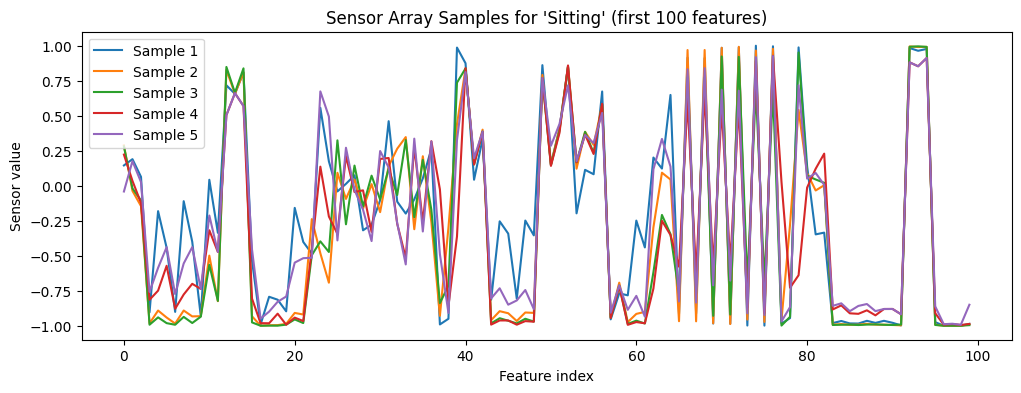

Plotted example sensor data for activity 'Sitting'.


In [175]:
# Plotting example array for an activity
print(assistant.handle_query("Show me data array for Sitting"))

In [172]:
# while True:
#     user_input = input("Your query (or 'exit'): ")
#     if user_input.lower() == 'exit':
#         break
#     # Add logic to parse/paste sensor data if needed
#     print(assistant.handle_query(user_input))